# Project 4: Predicting Outbreaks of West Nile Virus in Chicago

Group 2 Joint Submission: Derrick Hoe, Joyce Ooi, Nee Bimin, Cheong Yu Chye

## Notebook 3: Modelling

This notebook contains the code for model selection and evaluation.

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Data Preparation](#Data-Preparation)
- [Baseline Accuracy](#Baseline-Accuracy)
- [Handling of Imbalanced Classes](#Handling-of-Imbalanced-Classes)
- [Randomised Search for the Best Classifier](#Randomised-Search-for-the-Best-Classifier)
- [Selection of the Best Classifier](#Selection-of-the-Best-Classifier)
- [Further Exploration of the Best Classifier](#Further-Exploration-of-the-Best-Classifier)
    * [Logistic Regression Coefficients](#Logistic-Regression-Coefficient)
    * [ROC-AUC Curve](#ROC---AUC-Curve)
- [Cost-Benefit-Analysis](#Cost-Benefit-Analysis)
    * [Quantitative Cost Factors](#Quantitative-Cost-Factors)
    * [Qualitative Cost Factors](#Qualitative-Cost-Factors)
    * [Quantitative Benefit Factors](#Quantitative-Benefit-Factors)
    * [Qualitative Benefit Factors](#Qualitative-Benefit-Factors)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)
- [Generation of Predictions](#Generation-of-Predictions)
- [Data Export](#Data-Export)

## Importing of Libraries

In [1]:
# Read in libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from mpl_toolkits import mplot3d
from sklearn import ensemble, preprocessing
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
#modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline 

C:\Users\yuchy\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Import

In [2]:
# Import data from downloaded csv files
train = pd.read_csv('../assets/train_preproc.csv', )
test = pd.read_csv('../assets/test_preproc.csv')
spray = pd.read_csv('../assets/spray_clean.csv')
weather = pd.read_csv('../assets/weather_clean.csv')

In [3]:
train.shape, test.shape, spray.shape, weather.shape

((9693, 15), (116293, 15), (14294, 3), (2899, 5))

## Data Preparation

In [4]:
train = train.drop(['date'], axis = 1)
test = test.drop(['date'], axis = 1)

In [5]:
train.head()

,latitude,longitude,wnvpresent,preciptotal,tavg*wetbulb,wetbulb*dewpoint,tavg*wetbulb*dewpoint,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX
0,41.954690,-87.800991,0.0,0.0,4945.25,3831.75,289297.125,0,1,0,0,0,0,0
1,41.954690,-87.800991,0.0,0.0,4945.25,3831.75,289297.125,0,0,1,0,0,0,0
2,41.994991,-87.769279,0.0,0.0,4945.25,3831.75,289297.125,0,0,1,0,0,0,0
3,41.974089,-87.824812,0.0,0.0,4945.25,3831.75,289297.125,0,1,0,0,0,0,0
4,41.974089,-87.824812,0.0,0.0,4945.25,3831.75,289297.125,0,0,1,0,0,0,0


In [6]:
test.head()

,id,latitude,longitude,preciptotal,tavg*wetbulb,wetbulb*dewpoint,tavg*wetbulb*dewpoint,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS,species_UNSPECIFIED CULEX
0,1.0,41.95469,-87.800991,0.0,4800.0,3552.0,266400.0,0,1,0,0,0,0,0
1,2.0,41.95469,-87.800991,0.0,4800.0,3552.0,266400.0,0,0,1,0,0,0,0
2,3.0,41.95469,-87.800991,0.0,4800.0,3552.0,266400.0,1,0,0,0,0,0,0
3,4.0,41.95469,-87.800991,0.0,4800.0,3552.0,266400.0,0,0,0,1,0,0,0
4,5.0,41.95469,-87.800991,0.0,4800.0,3552.0,266400.0,0,0,0,0,0,1,0


In [7]:
train.shape, test.shape

((9693, 14), (116293, 14))

In [8]:
# X and Y variable
X = train.drop(columns = ['wnvpresent']) 
y = train['wnvpresent']

In [9]:
#Train Test split 
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [10]:
X_test = test.drop(['id'], axis=1)

## Baseline Accuracy

In [11]:
y_train.value_counts(normalize = True)

0.0    0.948136
1.0    0.051864
Name: wnvpresent, dtype: float64

We observe above that the baseline accuracy (for non-WNV-infected mosquitoes) is approximately 94.81%. The naive model will predict all 0s and will be correct 94.81% of the time.

## Handling of Imbalanced Classes

The baseline accuracy above indicates that the **training set is highly imbalanced** -- i.e. the wnvpresent=1 class takes up just 0.05% of all the mosquitoes caught.

To deal with this, we choose to oversample the minority class by creating synthetic samples using imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. We generate new samples **only in the training set** to ensure our model generalises well to unseen data.

In [12]:
from imblearn.over_sampling import SMOTE
# Instantiate a SMOTE object to oversample minority classes
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)
# check distribution of y_train after applying SMOTE
y_train.value_counts(normalize = True);

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [13]:
y_train.value_counts(normalize=True)

1.0    0.5
0.0    0.5
Name: wnvpresent, dtype: float64

As shown above, oversampling of the minority class (wnvpresent=1) has been performed, and there is now an equal distribution of WNV-infected and non-WNV-infected mosquitoes.

## Randomised Search for the Best Classifier

To manage the total time and resources used to tune the hyperparameters, we use the RandomizedSearchCV to randomly find the optimal parameters for each of the models based on the training dataset, with a maximum of 50 iterations. We specify the range of parameters to be used by RandomizedSearchCV for each classifer, based on experience and past results of running the RandomizedSearchCV.

We obtain the AUC score on the validation dataset for each classifier using the optimal parameters identified by RandomizedSearchCV. We will select the best classifier based on the **highest AUC score** found.

In [14]:
# We fit a StandardScaler() object on just the training dataset,
# then use the object to transform both the training and validation datasets
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_valid_sc = ss.transform(X_valid)
X_test_sc = ss.transform(X_test)

In [15]:
# We have selected the models below for modelling purposes.
estimators = {
    'lr': LogisticRegression(random_state=42),
    'knn': KNeighborsClassifier(),
    'ada': AdaBoostClassifier(random_state=42),
    'dtree': DecisionTreeClassifier(random_state=42),
    'rf': RandomForestClassifier(random_state=42),
    'etree': ExtraTreesClassifier(random_state=42)
}.items()

In [16]:
params = {
    'lr': {
        'lr__solver': ['liblinear'],
        'lr__penalty': ['l1', 'l2', 'elasticnet'],
        'lr__C': np.logspace(1, 5, 20)
    },
    'knn': {
        'knn__n_neighbors': [3, 5, 7, 9]
    },
    'ada': {
        'ada__n_estimators': [500, 1000, 1500, 2000],
        'ada__learning_rate': [1, 1.5, 2]
    },
    'dtree': {
        'dtree__max_depth': [25, 50, 75, 100],
        'dtree__max_features': ['auto', 'log2', None, 50, 100],
        'dtree__min_samples_split': [5, 10, 20, 30],
        'dtree__min_samples_leaf': [5, 10, 15, 20]
    },
    'rf': {
        'rf__max_depth': [1000, 2000, 3000, 4000],
        'rf__max_features': ['auto', 'log2', None, 50],
        'rf__min_samples_split': [2, 4, 6],
        'rf__min_samples_leaf': [1, 3, 5]
    },
    'etree': {
        'etree__max_depth': [40, 50, 60, 70],
        'etree__max_features': ['auto', 'log2', None, 50],
        'etree__min_samples_split': [2, 4, 6],
        'etree__min_samples_leaf': [1, 2, 3]
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best mean accuracy score based on the training dataset.

In [17]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
train_accuracy = []
val_accuracy = []
best_score = []
train_roc_auc = []
val_roc_auc = []
sensitivity = []

for k,v in estimators:
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter=50, # we set a max. of 50 iterations
        estimator=pipe,
        random_state=42,
        param_distributions=param,
        verbose=1,
        cv= 5,
        n_jobs=-1,
        return_train_score= True,
        scoring = 'roc_auc' # we adopt AUC score as our scoring metric as it is provides the best overall assessment
    )

    randomsearch.fit(X_train_sc, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_pred_train = model.predict(X_train_sc)
    y_pred_valid = model.predict(X_valid_sc)
    
    # print results
    print ("Model: ", k)
    print ("Best parameters:", best_params)
    print ("Best AUC cross validation score:", randomsearch.best_score_)
    print ("Training dataset accuracy:", accuracy_score(y_train,y_pred_train))
    print ("Validation dataset accuracy:", accuracy_score(y_valid,y_pred_valid))
    print ("Training dataset AUC score:", roc_auc_score(y_train,y_pred_train))
    print ("Validation dataset AUC score:", roc_auc_score(y_valid,y_pred_valid))
    # obtain true positive and false negatives to calculate sensitivity
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred_valid).ravel() 
    print ("Validation dataset sensitivity", tp/(tp+fn))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_accuracy.append(accuracy_score(y_train,y_pred_train))
    val_accuracy.append(accuracy_score(y_valid,y_pred_valid))
    train_roc_auc.append(roc_auc_score(y_train,y_pred_train))
    val_roc_auc.append(roc_auc_score(y_valid,y_pred_valid))
    sensitivity.append(tp/(tp+fn))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   54.4s finished


Model:  lr
Best parameters: {'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__C': 2069.13808111479}
Best AUC cross validation score: 0.795890317219247
Training dataset accuracy: 0.7058908879860708
Validation dataset accuracy: 0.681930693069307
Training dataset AUC score: 0.7058908879860708
Validation dataset AUC score: 0.6672157984168429
Validation dataset sensitivity 0.6507936507936508

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\yuchy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.5s finished


Model:  knn
Best parameters: {'knn__n_neighbors': 7}
Best AUC cross validation score: 0.9382604665396848
Training dataset accuracy: 0.9035113174695298
Validation dataset accuracy: 0.7871287128712872
Training dataset AUC score: 0.9035113174695298
Validation dataset AUC score: 0.6476853578681255
Validation dataset sensitivity 0.49206349206349204

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\yuchy\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.3min finished


Model:  ada
Best parameters: {'ada__n_estimators': 2000, 'ada__learning_rate': 1.5}
Best AUC cross validation score: 0.9779000117223159
Training dataset accuracy: 0.931442251886245
Validation dataset accuracy: 0.8989273927392739
Training dataset AUC score: 0.931442251886245
Validation dataset AUC score: 0.639137552322931
Validation dataset sensitivity 0.3492063492063492

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Model:  dtree
Best parameters: {'dtree__min_samples_split': 20, 'dtree__min_samples_leaf': 5, 'dtree__max_features': None, 'dtree__max_depth': 75}
Best AUC cross validation score: 0.9413607543650931
Training dataset accuracy: 0.9323128264654672
Validation dataset accuracy: 0.8597359735973598
Training dataset AUC score: 0.9323128264654672
Validation dataset AUC score: 0.6484727920759252
Validation dataset sensitivity 0.4126984126984127

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.8min finished


Model:  rf
Best parameters: {'rf__min_samples_split': 6, 'rf__min_samples_leaf': 1, 'rf__max_features': None, 'rf__max_depth': 2000}
Best AUC cross validation score: 0.9770945462506301
Training dataset accuracy: 0.9836041787579802
Validation dataset accuracy: 0.8960396039603961
Training dataset AUC score: 0.9836041787579802
Validation dataset AUC score: 0.6151104480086204
Validation dataset sensitivity 0.30158730158730157

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished


Model:  etree
Best parameters: {'etree__min_samples_split': 6, 'etree__min_samples_leaf': 1, 'etree__max_features': None, 'etree__max_depth': 50}
Best AUC cross validation score: 0.9759604899658333
Training dataset accuracy: 0.9818630295995356
Validation dataset accuracy: 0.8857260726072608
Training dataset AUC score: 0.9818630295995358
Validation dataset AUC score: 0.6509283434870903
Validation dataset sensitivity 0.3888888888888889

Wall time: 10min 34s


## Selection of the Best Classifier

In [18]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best AUC cross validation score': best_score,
    'Training dataset accuracy': train_accuracy,
    'Validation dataset accuracy': val_accuracy,
    'Training dataset AUC score': train_roc_auc,
    'Validation dataset AUC score': val_roc_auc,
    'Validation dataset sensitivity': sensitivity
    })

pd.set_option('display.max_colwidth', -1)
summary.sort_values('Validation dataset AUC score', ascending=False).reset_index(drop=True)

C:\Users\yuchy\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


,model,parameters,Best AUC cross validation score,Training dataset accuracy,Validation dataset accuracy,Training dataset AUC score,Validation dataset AUC score,Validation dataset sensitivity
0,lr,"{'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__C': 2069.13808111479}",0.795890,0.705891,0.681931,0.705891,0.667216,0.650794
1,etree,"{'etree__min_samples_split': 6, 'etree__min_samples_leaf': 1, 'etree__max_features': None, 'etree__max_depth': 50}",0.975960,0.981863,0.885726,0.981863,0.650928,0.388889
2,dtree,"{'dtree__min_samples_split': 20, 'dtree__min_samples_leaf': 5, 'dtree__max_features': None, 'dtree__max_depth': 75}",0.941361,0.932313,0.859736,0.932313,0.648473,0.412698
3,knn,{'knn__n_neighbors': 7},0.938260,0.903511,0.787129,0.903511,0.647685,0.492063
4,ada,"{'ada__n_estimators': 2000, 'ada__learning_rate': 1.5}",0.977900,0.931442,0.898927,0.931442,0.639138,0.349206
5,rf,"{'rf__min_samples_split': 6, 'rf__min_samples_leaf': 1, 'rf__max_features': None, 'rf__max_depth': 2000}",0.977095,0.983604,0.896040,0.983604,0.615110,0.301587


The table above shows the performance of the various models in terms of their optimal parameters, and the different metrics used to evaluate the models, namely accuracy, AUC scores and sensitivity. The classifiers are sorted based on descending order of the sensitivity score on the validation dataset.

We choose the **Logistic Regression** (lr) classifier as our best classifier, given that it has the highest AUC score on the validation dataset (0.667). Although it did not achieve an accuracy (i.e. 68.2%) higher than the baseline accuracy of 94.8% (extremely high due to imbalanced data), this is still a much better model because the baseline model will also never predict that a location has West Nile Virus, which may lead to outbreaks of the disease. Besides, we observe minimal overfitting of the model when comparing both the accuracy and AUC scores of the training and validation datasets.

Besides having the highest ROC-AUC score, the Logistic Regression model has the highest sensitivity (0.651), which is an important metric in this case. False negatives need to be reduced so that mosquito control measures can be done at all areas which have the virus.

## Further exploration of the Best Classifier

### Logistic Regression Coefficients

In [19]:
# We instantiate the logistic regression classifier based on the best parameters found above
lr_best = LogisticRegression(random_state=42, solver='liblinear', penalty='l1', C=1274.2749857031336)

In [20]:
# Fit the logistic regression classifier on the scaled training dataset
lr_best.fit(X_train_sc, y_train)

LogisticRegression(C=1274.2749857031336, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

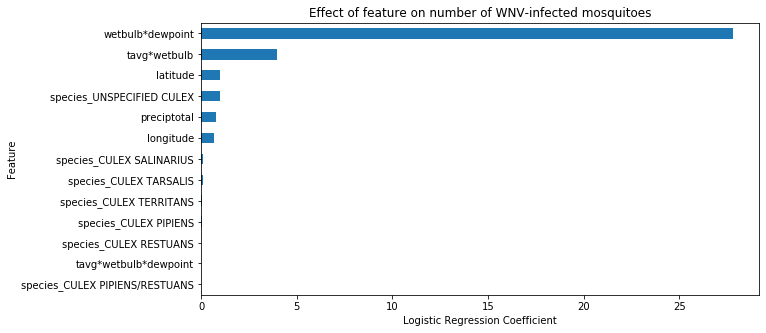

In [21]:
# Generate a plot of the logistic regression coefficients
# The coefficients are exponentiated to reverse the effect of logistic regression
fig = plt.figure(figsize=(10,5))
feature_scores = pd.DataFrame(np.exp(lr_best.coef_), columns=X.columns)
feature_scores.loc[0,:].sort_values(ascending=True).plot(kind='barh');
plt.xlabel("Logistic Regression Coefficient")
plt.ylabel("Feature")
plt.title("Effect of feature on number of WNV-infected mosquitoes");

**Findings:**

*wetbulb * dewpoint*

The coefficient which is most significant is the interaction term wetbulb * dewpoint.
Wet bulb temperature measures the temperature with the bulb of the thermometer wrapped in wet cloth. The idea is that as water evaporates from the cloth, the temperature drops. This is a useful method of measurement because the more saturated with moisture the air is, the less evaporation occurs and the less cooling there is.

The dew point temperature, on the other hand, is the temperature at which moisture in the air starts to condense, as it does during the formation of dew. Like wet bulb temperature, the dew point really shows the relationship between temperature and humidity, but it does it in a different way.

Wet bulb temperature can be thought of as a measure of water evaporation while dew point temperature can be seen as a measure of water condensation. Since both variables are measures of humidity, it makes sense that they are important variables in predicting whether the virus is present. Based on the PubMed Central article ([Climate change impacts on West Nile virus transmission in a global context](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/)), relative humidity correlates positively with:
* vector population dynamics
* morbidity in humans
 
Thus, we can infer that as relative humidity goes up, the mosquito population size increases and morbidity in humans also increase.

*tavg * wetbulb*

The second most significant interaction term is related to humidity and temperature. According to the same article, temperature correlates positively with:
* viral replication rates
* seasonal phenology of mosquito host populations
* growth rates of vector populations
* geographical variations in human case incidence

We can infer that as this humidity and temperature interaction term increases, there should be a corresponding rise in the presence of the virus given that viral replication rates and the growth rate of mosquito populations will increase. These will lead to higher geographical variations in human case incidence.

### ROC-AUC Curve

In [22]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validation set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr_best.predict_proba(X_valid_sc)]

pred_df = pd.DataFrame({'true_values': y_valid,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
8914,0.0,0.228475
6079,0.0,0.668096
2279,0.0,0.443008
9369,1.0,0.721823
4835,0.0,0.662433


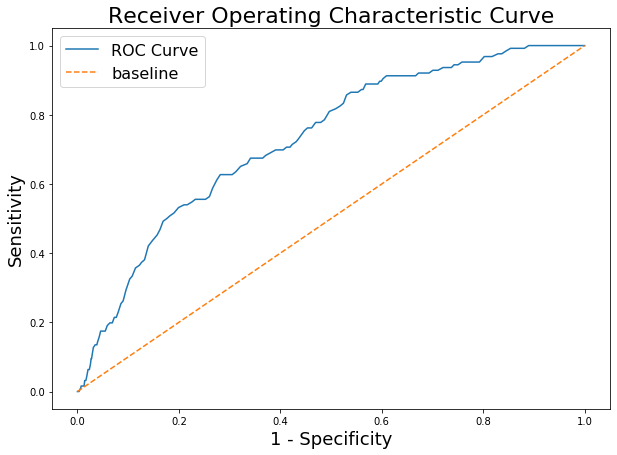

In [23]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

**Interpreting ROC AUC**

ROC is a probability curve and AUC represents the degree of separability i.e. the capability of the model in distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. If AUC is 1, the positive (wnvpresent = 1) and negative populations (wnvpresent = 0) are perfectly separated. Here, we have an AUC of 0.667216.

---
## Cost-Benefit Analysis


We can quantify the costs of pesticide spraying by looking at the explicit costs associated with spray implementation.

Approximately USD 2.6M spray cost :

### Quantitative Cost Factors

**Method 1**

1. Cost of Zenivex E4 = USD 80 per gallon (https://www.cmmcp.org/pesticide-information/pages/zenivex-e4-etofenprox)
2. Estimated cost of pesticides for each sprayer truck is USD 800-1,600 (based on spraying at 4.5 - 9 ounces per minute, at a vehicle speed of 10 - 15 mph)
3. Estimated cost of pesticides for all sprayer trucks is USD 1.6M in total (based on 1,000 trucks requires to cover the total area of Chicago is 606.1 km (http://www.gfmosquito.com/wp-content/uploads/2013/06/2013-North-Dakota-Bid-Tabulation.pdf)

Total cost = USD 1.6-3.25M

**Method 2**

4. Cost of spray trucks (USD 400-650 per hour x 5 hrs x 1,000 trucks = USD 2-3.25M) (http://meepi.org/wnv/overkillma.htm)
5. Miscellaneous advertising costs related to mosquito control notices

### Qualitative Cost Factors

Human and ecologic risks associated with the pesticide spray(http://envinfo.org/appendix%20ii-c.html)

### Quantitative Benefit Factors

We can quantify the benefit of pesticide spraying by looking at the aversion of loss of income which could have resulted from WNV. 	

Approximately USD $1.23M from medical/hospitalization expenses and loss of income due to WNV, as follows:

1. Potential aversion of loss in household income:

	- The annual median household income in Chicago was USD 57,238, as of 2018  and can be used as an estimate to measure the loss of income during patient recovery from WNV. https://datausa.io/profile/geo/chicago-il/
	- Given that 1 in 5 experience symptoms such as headache, body aches, joint pains, vomiting, diarrhea, or rash , this could mean that approximately 35 people out of 176 may have been hospitalized or received medical treatment.https://www.cdc.gov/westnile/symptoms/index.html If these were working adults and required two weeks off work to recover, this would have resulted in a total loss of income of USD 2,200 per patient over 2 weeks or USD 77,000 for 35 patients.


2. Potential aversion of hospital and medical expenses:

	- Method 1: In 2018, there were 176 WNV cases reported in Illinois where Chicago  is located.  On average, each WNV patient spends approximately USD 33,143 per inpatient and USD 6,317 per outpatient for all treatments. Total cost of 35 patients would amount to 1,160,005. Therefore the total monetary loss caused by WNV in 2018 could be as high as USD 1,237,005 in total https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011
	- Method 2: Studies have shown that the WNV hospitalization costs are annually USD 56M for the United States. If we divide this amount by 50 states, this amounts to USD 1.12M a year for Illinois where Chicao is located. https://www.sciencedaily.com/releases/2014/02/140210184713.htm


3. Potential aversion of medical expensess of non-WNV issues
Our analysis also does not include medical costs associated with non-WNV issues which may have been resolved through spraying of pesticides, such as mosquito-bite allergenicity or potential adverse sequelae, which are unaccounted for but may be significant.

4. Potential aversion of loss of income in business or tourism: more data is required on this

### Qualitative Benefit Factors

1. Pain and distress are difficult to quantify monetarily
2. Averted medical costs associated with non-WNV issues are difficult to account for
3. Benefits from mosquito spraying such as increased quality of life from fewer people falling sick and increased workplace productivity from fewer people falling ill and going on medical leave, are less easily quantifiable.

### Cost-benefit Assessment

It is inconclusive that benefits of pesticide spraying exceeded its costs. Based on quantitative analysis, the actual/realised monetary costs associated with spraying appear to exceed the benefits. However, given that WNV cases may be underestimated and factoring in the qualitative factors, mentioned above, results are inconclusive. Regarding unreported figures, the actual number of persons affected with WNF remains unknown as the total number of WNF cases have been underreported or underdiagnosed. The Centers for Disease control estimates that for every confirmed case, there’s 30 to 60 cases that go unreported. (https://www.abc10.com/article/news/local/)


---
## Conclusions and Recommendations

### A. Our Classifier

We have trained a classifier to predict when and where different species of mosquitos will test positive for West Nile Virus (WNV). Our classifier is a Logistic Regression which gives a rather high sensitivity rate of 65% .

**Limitations**

1. The limitation of this model lies in the use of time-series data which could mean that the data is autocorrelated. This can lead to implications on the computation of standard errors.
2. More data is required for more accurate analysis. Earlier EDA revealed that spraying was only done in 2011 and 2013, and mostly in September. As this is near the end of summer, breeding conditions were already becoming less favourable for mosquitos, hence it would be difficult to discern the effects of spraying from the natural decline in mosquito populations. Further examinations of spraying efforts in 2013 August also did not reveal any noticeable decrease in WNV occurrences.

**Areas for further investigation**

We have yet to explore the variable of number of mosquitoes. A larger population size of mosquitoes would mean that there are more mosquitoes which can become infected, and it also increases the number of interactions among hosts, allowing for a faster spread of the virus. The size of the population could be estimated from the number of mosquitoes found in each trap. However, as this variable is not present in the test set, we dropped it from our training dataset. In future analysis, we could impute the value from other variables so that it can be used as an input.

### B. Further Efforts in Spraying

Based on our observations, the duration and magnitude of spraying could be improved, as mentioned below.

**Focus on Sensitivity**

The sensitivity of our model to detect WNV is 65%. (we can tune parameters to get different results)

We view sensitivity as a priority as the cost and tolerance of falsely spraying areas (ones that are not infested) is high for the Chicago Municipality. Based on solvency, Illinois where Chicago is located, has between 0.55 and 1.13 times the cash needed to cover short-term obligations and ranks 50th among the US states for fiscal health, well below the US average (https://www.mercatus.org/publications/50-ranking-states-fiscal-condition-illinois).

Hence the cost of overspending is high.

We choose to focus less on specificity in the case of Chicago as it is one of the healthiest states in US (https://news.wttw.com/2017/02/17/chicago-ranked-one-healthiest-cities-us). Hence we infer that false negatives is a less serious issue.

**A Targeted Approach**

1. Targeting WNV geographic clusters that we identified in our EDA, so as to allow for broader coverage.
2. Increase spraying frequency during WNV seasonal periods, as identified during our EDA, such as in August where mosquitoes numbers tend to increase.
3. Targeting of one species (Culex Pipiens, Culex Pipiens/Restuans) which stands out as a carrier with higher rates of WNV in our EDA. We propose reducing this species in particular through targeted biological mosquito control which would make spraying more efficient and less costly.

As 14,244 sprays were conducted over 10 days, this could be viewed as excessive and temporal. Our EDA comparing spray locations and WNV incidences also suggests that spray efficacy could be limited since incidences of WNV were still present during periods after pesticide spray.

**A Holistic Approach**

1. Implementing other vector control measures such as education campaigns (such as using insect repellents and emptying water from containers to reduce exposure) (http://phsneb.org/programs/population-protection/environmental/west-nile-virus/).
2. More use of larvicides instead of adulticides. Spraying of pesticides (adulticides) mainly works against winged mosquitoes as compared to larvicides that work in standing water against mosquito larvae. Larvicides can be targeted to mosquito breeding sites, which could help to reduce cost. Given that there are over 210,000 catch basins in Chicago which are excellent breeding grounds for mosquitoes, more frequent use of larvicides could be carried out (https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/svcs/report_standing_water.html).


## Generation of Predictions

In [24]:
# Generate the predictions based on the scaled testing dataset
y_pred = pd.DataFrame(lr_best.predict(X_test_sc), columns=['wnvpresent'])

In [25]:
# Concatenate the predictions with the X_test dataframe
test_pred = pd.concat([X_test, y_pred], axis=1)

In [26]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test_pred, test['id']], axis=1)

In [27]:
# Verify that we have a mix of predictions for WNV
test_pred['wnvpresent'].value_counts()

0.0    75332
1.0    40961
Name: wnvpresent, dtype: int64

## Data Export

In [28]:
test_pred.to_csv("../assets/test_pred.csv", index=False)